<a href="https://colab.research.google.com/github/balazsivanyi/ML_miniproject/blob/main/ML_miniproject_balazsivanyi_CLEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session-aware music recommendation ML algorithm on Spotify datasets

## Install and setup phase

Importing libraries and dependencies for the project. 

In [3]:
%matplotlib inline

import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA

#import json 
#import time 
#import sys

Setting up final dataframe

In [4]:
#loading in track audio features data
trackData1 = pd.read_csv('/content/drive/MyDrive/ML_miniproject_2021/tf_000000000000.csv')                           
trackData2 = pd.read_csv('/content/drive/MyDrive/ML_miniproject_2021/tf_000000000001.csv')

#combine into one dataframe                               
trackData = pd.concat([trackData1, trackData2], ignore_index=True)
print('Total number of tracks: {}'.format(len(trackData)))

Total number of tracks: 3706388


In [5]:
# Spotify streaming session data
userData = pd.read_csv('/content/drive/MyDrive/ML_miniproject_2021/log_0_20180815_000000000000.csv')
print('Total number of user interaction logs: {}'.format(len(userData)))

#check if streaming data is not missing any songs
set(userData.track_id_clean).issubset(set(trackData.track_id))

Total number of user interaction logs: 3105679


True

In [6]:
#check columns of track dataframe
trackData.columns

Index(['track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7'],
      dtype='object')

In [7]:
#check columns of user interaction dataframe
userData.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [8]:
#renaming columns to match in the two dataframes
userData = userData.rename(columns={'track_id_clean': 'track_id'})

#matching and merging dataframes by track_id column
mergedData = userData.merge(trackData, how='left', on="track_id")

#remapping major and minor from string to binary values
mergedData['mode'] = mergedData['mode'].map({'major': 1, 'minor': 0})

mergedData.columns

Index(['session_id', 'session_position', 'session_length', 'track_id',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7'],
      dtype='object

In [9]:
#deleting last columns, which won't be used for feature engineering
mergedData = mergedData.drop(['acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7'], axis=1)

#displaying an excerpet of the dataframe for checking
mergedData.head(10)

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,1,20,t_86abc9b1-2a71-41d8-ab97-ac97ea20276a,True,True,True,False,0,0,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,200.546677,2006,99.997576,0.000059,0.205253,0.191648,0.390629,4.778084,0.963439,0.930136,6.890018e-02,10,0.140413,-4.378,0.777542,0,0.157301,0.077345,167.065002,4,0.363948
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,2,20,t_33a133e6-240c-467d-a5c5-a6729a545cc2,True,True,True,False,0,0,1,1,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,246.519730,2015,97.391548,0.000445,0.197883,0.172790,0.228356,4.468809,0.890128,0.968709,2.377608e-01,11,0.307806,-2.373,0.334852,0,0.470331,0.060110,138.798996,5,0.475900
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,3,20,t_cd87b117-d9d0-4562-b469-65ae0e88f8f5,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,230.213333,2015,99.961404,0.090172,0.367402,0.333184,0.541190,5.807304,0.643394,0.982674,9.846400e-09,3,0.152956,-5.517,0.627907,0,0.270725,0.036610,90.060997,4,0.491455
3,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,4,20,t_de6bfde1-10b3-4984-add7-b41050bc9353,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,207.786667,2017,99.999173,0.422664,0.268346,0.280567,0.277216,5.783823,0.393620,1.011296,6.704910e-07,8,0.095243,-8.903,0.169231,1,0.659099,0.033571,86.777000,3,0.226621
4,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,5,20,t_01d7104d-d28c-4c56-9012-d22ef2b8bdc9,False,False,False,True,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,trackdone,195.518997,2018,99.999788,0.002812,0.496197,0.445518,0.630482,6.607257,0.694285,1.031873,1.266271e-10,11,0.071866,-6.257,0.773723,0,0.160015,0.025284,97.004997,4,0.215933
5,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,6,20,t_ff674955-20ad-48bf-8494-d5fbe9dd7fac,False,False,True,False,0,0,1,1,0,0,True,8,2018-08-14,True,user_collection,trackdone,fwdbtn,245.053329,2011,93.858501,0.068239,0.349181,0.350332,0.602128,6.290171,0.795717,0.963909,1.196051e-01,0,0.149576,-3.657,0.570766,0,0.307326,0.103283,126.059998,4,0.264787
6,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,7,20,t_0478077e-cc90-48f5-a989-21714d69151d,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,174.226669,2018,99.895486,0.590150,0.543267,0.535417,0.537070,7.862614,0.596715,1.040544,1.141131e-05,7,0.100791,-7.641,0.532663,0,0.532297,0.071800,79.959999,4,0.388015
7,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,8,20,t_3c70d8ac-b601-4f8e-be57-cfdb7f119183,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,227.533325,2017,99.999812,0.627452,0.496016,0.589231,0.670188,9.350102,0.654282,1.025306,1.021170e-06,4,0.071018,-5.944,0.820244,1,0.461523,0.153234,180.024002,4,0.437593
8,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,9,20,t_048f0e89-bdcb-4d33-bcea-a4f4c3591cc4,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,268.866669,2017,99.999286,0.053429,0.461715,0.462736,0.588504,7.273110,0.730975,1.014365,1.496789e-10,2,0.307783,-6.343,0.510145,1,0.348434,0.086839,87.907997,4,0.190725
9,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,10,20,t_52fc9bcf-ce50-43fc-9498-c2c8421a33e7,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,222.653336,2018,99.999710,0.044075,0.575090,0.579509,0.736817,8.417690,0.636002,1.039552,6.660252e-05,11,0.350031,-4.546,0.771015,0,0.164889,0.

In [10]:
#check details of merged dataframe
mergedData.info()
mergedData.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105679 entries, 0 to 3105678
Data columns (total 42 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   session_id                       object 
 1   session_position                 int64  
 2   session_length                   int64  
 3   track_id                         object 
 4   skip_1                           bool   
 5   skip_2                           bool   
 6   skip_3                           bool   
 7   not_skipped                      bool   
 8   context_switch                   int64  
 9   no_pause_before_play             int64  
 10  short_pause_before_play          int64  
 11  long_pause_before_play           int64  
 12  hist_user_behavior_n_seekfwd     int64  
 13  hist_user_behavior_n_seekback    int64  
 14  hist_user_behavior_is_shuffle    bool   
 15  hour_of_day                      int64  
 16  date                             object 
 17  premium 

session_id                         0
session_position                   0
session_length                     0
track_id                           0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
date                               0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
duration                           0
release_year                       0
us_popularity_estimate             0
acousticness                       0
beat_strength                      0
bounciness                         0
d

In [11]:
%matplotlib inline

import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA

#import json 
#import time 
#import sys

## Exploratory Data Analysis & Feature engineering

In [12]:
#number of skipped songs
mergedData.not_skipped.value_counts()

False    2021717
True     1083962
Name: not_skipped, dtype: int64

In [13]:
#number of different user listening sessions
mergedData.session_id.nunique()

188450

### Pairwise plot of audio feautres

In [ ]:
#audio_features = ['duration', 'release_year', 'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
#'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
#'time_signature', 'valence', 'not_skipped']
#sb.pairplot(data = balancedData.sample(frac=.0001, replace=False, random_state=7)[audio_features], hue='not_skipped', palette='Set2', height=2, plot_kws={"s":7});


### Minimum-Redundancy-Maximum-Relevance

Aiming for dimensionality reduction for kNN model

In [49]:
!pip install git+https://github.com/smazzanti/mrmr

  Cloning https://github.com/smazzanti/mrmr to /tmp/pip-req-build-huzityeu
  Running command git clone -q https://github.com/smazzanti/mrmr /tmp/pip-req-build-huzityeu
     |████████████████████████████████| 82 kB 433 kB/s 
  Created wheel for mrmr: filename=mrmr-0.1-py3-none-any.whl size=16139 sha256=a24a4b80395271e0768d80a9a6c0492ec77b1afa02dfd2b7a605386dbab00536
  Stored in directory: /tmp/pip-ephem-wheel-cache-rnjxr44v/wheels/97/75/f0/1af73f24fe1c223090326fd094140b43c61420a721e0ace303
Successfully built mrmr


In [14]:
from mrmr import mrmr_classif
from sklearn.datasets import make_classification

# create some data
X, y = make_classification(n_samples = 10000, n_features = 42, n_informative = 10, n_redundant = 32)
X = mergedData
y = mergedData['not_skipped'].squeeze()

# use mrmr classification
selected_features = mrmr_classif(X, y, K = 10)
print(selected_features)

100%|██████████| 10/10 [00:24<00:00,  2.45s/it]

['not_skipped', 'hist_user_behavior_reason_end', 'skip_3', 'skip_2', 'skip_1', 'session_id', 'hist_user_behavior_reason_start', 'short_pause_before_play', 'track_id', 'hist_user_behavior_n_seekfwd']


In [15]:
#keeping selected features only in the dataframe
mergedDataTemp = mergedData[mergedData.columns.difference(selected_features)]
mergedDataReduced = mergedData[mergedData.columns.drop(mergedDataTemp)]
mergedDataReduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105679 entries, 0 to 3105678
Data columns (total 10 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   session_id                       object
 1   track_id                         object
 2   skip_1                           bool  
 3   skip_2                           bool  
 4   skip_3                           bool  
 5   not_skipped                      bool  
 6   short_pause_before_play          int64 
 7   hist_user_behavior_n_seekfwd     int64 
 8   hist_user_behavior_reason_start  object
 9   hist_user_behavior_reason_end    object
dtypes: bool(4), int64(2), object(4)
memory usage: 257.7+ MB


## Simple kNN implementation with reduced data

In [16]:
%%capture
!pip install wandb

In [17]:
import wandb
wandb.login()

wandb: Currently logged in as: 101010 (use `wandb login --relogin` to force relogin)


True

In [18]:
#balancing out dataset on skipped - not skipped songs
balancedDataReduced = mergedDataReduced.groupby('not_skipped', group_keys=False).apply(lambda x: x.sample(1000000))
balancedDataReduced.not_skipped.value_counts()

True     1000000
False    1000000
Name: not_skipped, dtype: int64

In [19]:
#splitting inputs and target variable
X = balancedDataReduced.drop(columns = ['not_skipped']) #input
y = balancedDataReduced['not_skipped'].values #target

X.info()
print(y[0:])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 447207 to 1502912
Data columns (total 9 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   session_id                       object
 1   track_id                         object
 2   skip_1                           bool  
 3   skip_2                           bool  
 4   skip_3                           bool  
 5   short_pause_before_play          int64 
 6   hist_user_behavior_n_seekfwd     int64 
 7   hist_user_behavior_reason_start  object
 8   hist_user_behavior_reason_end    object
dtypes: bool(3), int64(2), object(4)
memory usage: 112.5+ MB
[False False False ...  True  True  True]


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#encoding target variable to binary
lb = LabelEncoder()
y_encoded = lb.fit_transform(y)
print(y_encoded)

#converting string into categorical data

X.session_id = pd.Categorical(X.session_id)
X['session_id'] = X.session_id.cat.codes

X.track_id = pd.Categorical(X.track_id)
X['track_id'] = X.track_id.cat.codes

X.hist_user_behavior_reason_start = pd.Categorical(X.hist_user_behavior_reason_start)
X['hist_user_behavior_reason_start'] = X.hist_user_behavior_reason_start.cat.codes

X.hist_user_behavior_reason_end = pd.Categorical(X.hist_user_behavior_reason_end)
X['hist_user_behavior_reason_end'] = X.hist_user_behavior_reason_end.cat.codes

#checking if datatypes are appropriate for training
X.info()

[0 0 0 ... 1 1 1]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 447207 to 1502912
Data columns (total 9 columns):
 #   Column                           Dtype
---  ------                           -----
 0   session_id                       int32
 1   track_id                         int32
 2   skip_1                           bool 
 3   skip_2                           bool 
 4   skip_3                           bool 
 5   short_pause_before_play          int64
 6   hist_user_behavior_n_seekfwd     int64
 7   hist_user_behavior_reason_start  int8 
 8   hist_user_behavior_reason_end    int8 
dtypes: bool(3), int32(2), int64(2), int8(2)
memory usage: 70.6 MB


In [21]:
#splitting dataset between test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 5)

# Fit the classifier to the data
knn.fit(X_train,y_train)

#show model predictions on the test data
y_pred = knn.predict(X_test)

#check accuracy of our model on the test data
knn.score(X_test, y_test)

y_probas = knn.predict_proba(X_test)

In [23]:
knn.score(X_test, y_test)

0.51627

## Moving away from kNN implementation and using full dataset again

### Feature analysis with correlation matrices

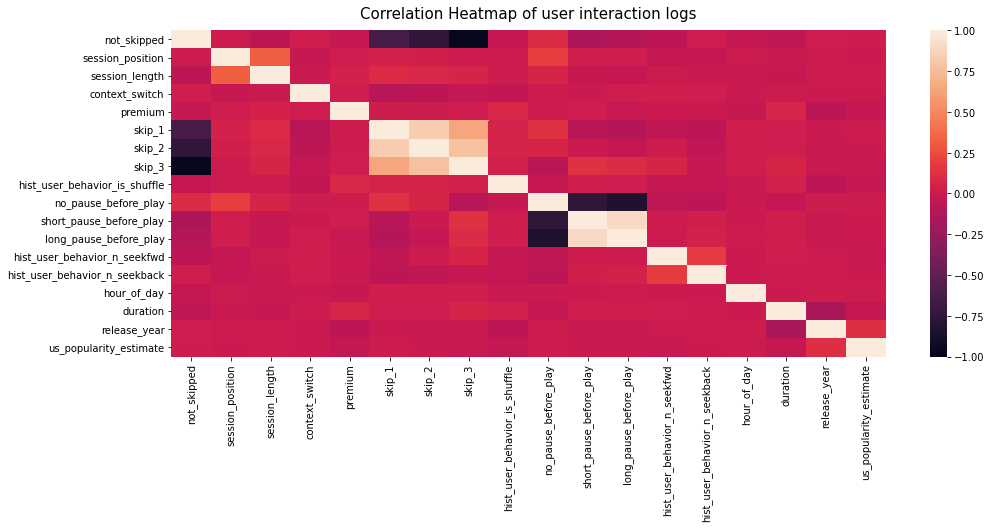

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sb.heatmap(mergedData[['not_skipped', 
                                   'session_position', 
                                   'session_length', 
                                   'track_id', 
                                   'context_switch', 
                                   'premium', 
                                   'skip_1', 
                                   'skip_2', 
                                   'skip_3',
                                   'hist_user_behavior_is_shuffle',
                                   'no_pause_before_play', 
                                   'short_pause_before_play',
                                   'long_pause_before_play',
                                   'hist_user_behavior_n_seekfwd',
                                   'hist_user_behavior_n_seekback',
                                   'hour_of_day',
                                   'date',
                                   'duration',
                                   'release_year',
                                   'us_popularity_estimate']].corr(), vmin=-1, vmax=1, annot=False);
heatmap.set_title('Correlation Heatmap of user interaction logs', fontdict={'fontsize':15}, pad=12);


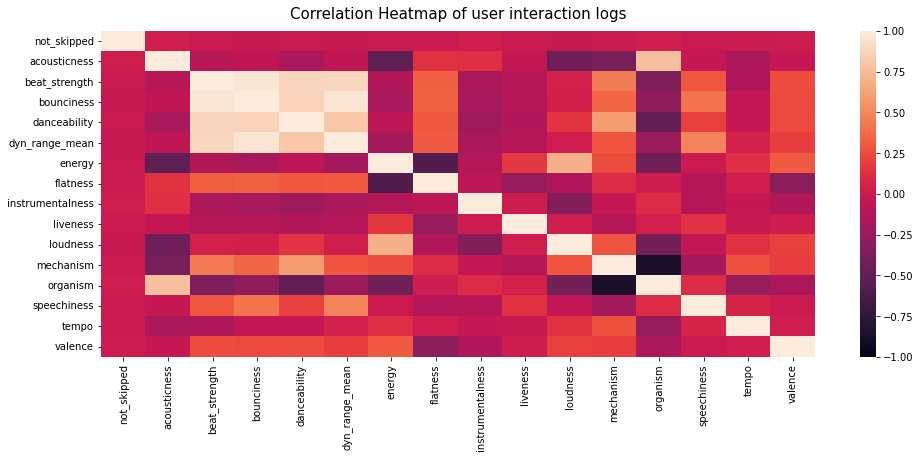

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sb.heatmap(mergedData[['not_skipped', 'acousticness', 'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
              'energy', 'flatness', 'instrumentalness', 'liveness', 'loudness',
              'mechanism', 'organism', 'speechiness', 'tempo', 'valence']].corr(), vmin=-1, vmax=1, annot=False);
heatmap.set_title('Correlation Heatmap of user interaction logs', fontdict={'fontsize':15}, pad=12);


### Importing previously cleaned data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spotify_skip.csv')

In [ ]:
#displaying the first few rows
data.head(5)

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,1,20,t_86abc9b1-2a71-41d8-ab97-ac97ea20276a,True,True,True,False,0,0,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,200.546677,2006,99.997576,0.000059,0.205253,0.191648,0.390629,4.778084,0.963439,0.930136,6.890018e-02,10,0.140413,-4.378,0.777542,0,0.157301,0.077345,167.065002,4,0.363948
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,2,20,t_33a133e6-240c-467d-a5c5-a6729a545cc2,True,True,True,False,0,0,1,1,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,246.519730,2015,97.391548,0.000445,0.197883,0.172790,0.228356,4.468809,0.890128,0.968709,2.377608e-01,11,0.307806,-2.373,0.334852,0,0.470331,0.060110,138.798996,5,0.475900
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,3,20,t_cd87b117-d9d0-4562-b469-65ae0e88f8f5,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,230.213333,2015,99.961404,0.090172,0.367402,0.333184,0.541190,5.807304,0.643394,0.982674,9.846400e-09,3,0.152956,-5.517,0.627907,0,0.270725,0.036610,90.060997,4,0.491455
3,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,4,20,t_de6bfde1-10b3-4984-add7-b41050bc9353,True,True,True,False,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn,207.786667,2017,99.999173,0.422664,0.268346,0.280567,0.277216,5.783823,0.393620,1.011296,6.704910e-07,8,0.095243,-8.903,0.169231,1,0.659099,0.033571,86.777000,3,0.226621
4,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,5,20,t_01d7104d-d28c-4c56-9012-d22ef2b8bdc9,False,False,False,True,0,1,0,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,trackdone,195.518997,2018,99.999788,0.002812,0.496197,0.445518,0.630482,6.607257,0.694285,1.031873,1.266271e-10,11,0.071866,-6.257,0.773723,0,0.160015,0.025284,97.004997,4,0.215933


### Reformatting features' datatypes for optimal training performance

In [ ]:
#feature variable types

#categorical
cat_variable = ['mode', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
for c in cat_variable:
    data[c] = data[c].astype('category')

#boolean
bool_variable = ['context_switch', 'no_pause_before_play', 'short_pause_before_play', 'long_pause_before_play',
                'not_skipped', 'premium', 'hist_user_behavior_is_shuffle']
for b in bool_variable:
    data[b] = data[b].astype('bool')

#ID
id_variable = ['session_id', 'track_id', 'date']
for i in id_variable:
  le = LabelEncoder()
  data[i] = le.fit_transform(data[i])

data.head(30)

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence
0,0,1,20,188256,True,True,True,False,False,False,False,False,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,200.546677,2006,99.997576,0.000059,0.205253,0.191648,0.390629,4.778084,0.963439,0.930136,6.890018e-02,10,0.140413,-4.378,0.777542,0,0.157301,0.077345,167.065002,4,0.363948
1,0,2,20,72365,True,True,True,False,False,False,True,True,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,246.519730,2015,97.391548,0.000445,0.197883,0.172790,0.228356,4.468809,0.890128,0.968709,2.377608e-01,11,0.307806,-2.373,0.334852,0,0.470331,0.060110,138.798996,5,0.475900
2,0,3,20,287825,True,True,True,False,False,True,False,False,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,230.213333,2015,99.961404,0.090172,0.367402,0.333184,0.541190,5.807304,0.643394,0.982674,9.846400e-09,3,0.152956,-5.517,0.627907,0,0.270725,0.036610,90.060997,4,0.491455
3,0,4,20,311489,True,True,True,False,False,True,False,False,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,207.786667,2017,99.999173,0.422664,0.268346,0.280567,0.277216,5.783823,0.393620,1.011296,6.704910e-07,8,0.095243,-8.903,0.169231,1,0.659099,0.033571,86.777000,3,0.226621
4,0,5,20,2588,False,False,False,True,False,True,False,False,0,0,True,8,52,True,user_collection,fwdbtn,trackdone,195.518997,2018,99.999788,0.002812,0.496197,0.445518,0.630482,6.607257,0.694285,1.031873,1.266271e-10,11,0.071866,-6.257,0.773723,0,0.160015,0.025284,97.004997,4,0.215933
5,0,6,20,357808,False,False,True,False,False,False,True,True,0,0,True,8,52,True,user_collection,trackdone,fwdbtn,245.053329,2011,93.858501,0.068239,0.349181,0.350332,0.602128,6.290171,0.795717,0.963909,1.196051e-01,0,0.149576,-3.657,0.570766,0,0.307326,0.103283,126.059998,4,0.264787
6,0,7,20,6243,True,True,True,False,False,True,False,False,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,174.226669,2018,99.895486,0.590150,0.543267,0.535417,0.537070,7.862614,0.596715,1.040544,1.141131e-05,7,0.100791,-7.641,0.532663,0,0.532297,0.071800,79.959999,4,0.388015
7,0,8,20,84573,True,True,True,False,False,True,False,False,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,227.533325,2017,99.999812,0.627452,0.496016,0.589231,0.670188,9.350102,0.654282,1.025306,1.021170e-06,4,0.071018,-5.944,0.820244,1,0.461523,0.153234,180.024002,4,0.437593
8,0,9,20,6378,True,True,True,False,False,True,False,False,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,268.866669,2017,99.999286,0.053429,0.461715,0.462736,0.588504,7.273110,0.730975,1.014365,1.496789e-10,2,0.307783,-6.343,0.510145,1,0.348434,0.086839,87.907997,4,0.190725
9,0,10,20,115764,True,True,True,False,False,True,False,False,0,0,True,8,52,True,user_collection,fwdbtn,fwdbtn,222.653336,2018,99.999710,0.044075,0.575090,0.579509,0.736817,8.417690,0.636002,1.039552,6.660252e-05,11,0.350031,-4.546,0.771015,0,0.164889,0.043701,105.004997,4,0.564775


In [ ]:
#importing sklearn libraries for training
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import lightgbm as lgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn import datasets, cluster

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [ ]:
#reparsing data so skipped — not skipped ratio is balanced for training
balancedData = data.groupby('not_skipped', group_keys=False).apply(lambda x: x.sample(1000000))

balancedData.not_skipped.value_counts()

True     1000000
False    1000000
Name: not_skipped, dtype: int64

In [ ]:
#splitting features for training
audio_features = ['duration', 'us_popularity_estimate', 'time_signature', 'key', 'mode', 'acousticness', 'beat_strength', 'bounciness', 
              'danceability', 'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'liveness', 'loudness', 'mechanism', 
              'organism', 'speechiness', 'tempo', 'valence']

user_interaction = ['context_switch', 'no_pause_before_play', 'short_pause_before_play', 'long_pause_before_play', 
                    'hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle', 
                    'hour_of_day', 'premium', 'context_type']

### Training with Gradient Boosted Trees algorithm (LightGBM) — first audio features only

In [ ]:
#separating target variable (not_skipped) and input features from dataframe
X_input = balancedData[audio_features] #first training only on audio characters
y_target = balancedData['not_skipped']

In [ ]:
#splitting dataframe between train, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X_input, y_target, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

X_train.shape, X_val.shape, X_test.shape

((1440000, 20), (360000, 20), (200000, 20))

In [ ]:
#importing weights & biases project
!pip install wandb
import wandb

wandb.init(project="spotify_skip_predict", entity="101010")

In [ ]:
#training light gradient boosted tree model on audio features only
model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_probas = model.predict_proba(X_test)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.806


### Training with user interactions and audio features — all the previously selected features

In [ ]:
#separating target variable (not_skipped) and input features from dataframe
X_input = balancedData[audio_features + user_interaction] #training on all the features
y_target = balancedData['not_skipped']

In [ ]:
#splitting dataframe between train, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X_input, y_target, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

X_train.shape, X_val.shape, X_test.shape

((1440000, 30), (360000, 30), (200000, 30))

In [ ]:
#training light gradient boosted tree model on all features
model = lgbm.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_probas = model.predict_proba(X_test)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.606


### Hyperparameter tuning with Weights & Biases

In [ ]:
#grid search sweep for hyperparameter tuning
sweep_config = {
    "name": "audio_user_feat_eng_2",
    "method": "grid",
    "metric": {
        "name": "accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "max_depth": {
            "values": [3, 5, 10, 15]
        },
        "num_leaves": {
            "values": [10, 20, 30]
        },
        "learning_rate": {
            "values": [.05, .1, .2]
        },
        "subsample": {
            "values": [1, .8, .5]
        }
    }
}

In [ ]:
def train():
    config_defaults = {
      "max_depth": 3,
      "num_leaves": 10,
      "learning_rate": .05,
      "subsample": 1,
    }
    wandb.init(project="spotify_skip_predict", entity="101010", config=config_defaults)
    config = wandb.config

    X_data = balancedData[audio_features + user_interaction]
    Y_data = balancedData['not_skipped']

    #splittin data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.9)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

    #fitting model on training set
    model = lgbm.LGBMClassifier(max_depth=config.max_depth,
                                num_leaves=config.num_leaves,
                                learning_rate=config.learning_rate, 
                                subsample=config.subsample)
    model.fit(X_train, y_train)

    #making predictions on test set
    y_pred = model.predict(X_val)

    #evaluating predictions
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {int(accuracy * 100.)}%")
    wandb.log({"accuracy": accuracy})

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="101010", project="spotify_skip_predict")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: qbsgqlqe
Sweep URL: https://wandb.ai/101010/spotify_skip_predict/sweeps/qbsgqlqe


In [ ]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 3c3ddmx8 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59443


wandb: Agent Starting Run: m1rk4ip5 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: Currently logged in as: 101010 (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59559


wandb: Agent Starting Run: sq9axlyf with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.5956


wandb: Agent Starting Run: x5h0qdfw with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59516


wandb: Agent Starting Run: xbtifkfi with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59518


wandb: Agent Starting Run: jw0bm2br with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59381


wandb: Agent Starting Run: dj6vj88u with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59539


wandb: Agent Starting Run: euossjmq with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59438


wandb: Agent Starting Run: qx8db5bq with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59507


wandb: Agent Starting Run: wqkc80n4 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.6003


wandb: Agent Starting Run: 7grdag9u with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59925


wandb: Agent Starting Run: zbajtikk with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60002


wandb: Agent Starting Run: ji2wvp88 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60019


wandb: Agent Starting Run: cx5p7agy with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60113


wandb: Agent Starting Run: q4o1cqmf with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60042


wandb: Agent Starting Run: plj4sxzn with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60137


wandb: Agent Starting Run: 4egde1qz with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60018


wandb: Agent Starting Run: i9k725h3 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60088


wandb: Agent Starting Run: 69uvv0cl with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59877


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pj0weeb4 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59906


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: law0hqgg with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60079


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j2pv0nh2 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60255


wandb: Agent Starting Run: d0ng0sub with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60267


wandb: Agent Starting Run: o9xr1vuc with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60328


wandb: Agent Starting Run: ztia5sfd with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60281


wandb: Agent Starting Run: m8l07bfc with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60525


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ggue9ge with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60397


wandb: Agent Starting Run: nd8878ot with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59927


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hodeoeg5 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59983


wandb: Agent Starting Run: 36p0d0qx with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60006


wandb: Agent Starting Run: ootqyz5k with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60351


wandb: Agent Starting Run: 736bfyxa with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60228


wandb: Agent Starting Run: xzdpiiqy with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60198


wandb: Agent Starting Run: y9op4hya with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60507


wandb: Agent Starting Run: 29qprpl1 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60411


wandb: Agent Starting Run: vqwbkxh8 with config:
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60451


wandb: Agent Starting Run: 7xftsalh with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60058


wandb: Agent Starting Run: sm6cz8gl with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60047


wandb: Agent Starting Run: ywiprgmv with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59934


wandb: Agent Starting Run: ypmh0qka with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59847


wandb: Agent Starting Run: x29revky with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59909


wandb: Agent Starting Run: x6a3d4t4 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59838


wandb: Agent Starting Run: xv6rvnsw with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59889


wandb: Agent Starting Run: gpgm6pax with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59878


wandb: Agent Starting Run: 81aozf31 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59737


wandb: Agent Starting Run: n2gej8ob with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.6023


wandb: Agent Starting Run: othdon27 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60222


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ezmrn857 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60311


wandb: Agent Starting Run: qwrcrk5j with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60398


wandb: Agent Starting Run: fic63rt4 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60365


wandb: Agent Starting Run: e4u8xfja with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60505


wandb: Agent Starting Run: 800s0cx5 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60366


wandb: Agent Starting Run: slzk7c4u with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.604


wandb: Agent Starting Run: wascw8ia with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60563


wandb: Agent Starting Run: wqv30dx3 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60325


wandb: Agent Starting Run: gutiwayq with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60273


wandb: Agent Starting Run: kdvmq4bf with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60252


wandb: Agent Starting Run: 7i69dmen with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60547


wandb: Agent Starting Run: 4na3frqb with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60439


wandb: Agent Starting Run: ytdc72iy with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60504


wandb: Agent Starting Run: 5y2qp8ec with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60633


wandb: Agent Starting Run: 51p6l43b with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60625


wandb: Agent Starting Run: k0t7bakz with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60762


wandb: Agent Starting Run: q5pb4v1x with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60364


wandb: Agent Starting Run: 4mkhy9c3 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60275


wandb: Agent Starting Run: xv9rps9f with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.6029


wandb: Agent Starting Run: vnhygfkh with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60532


wandb: Agent Starting Run: nfvkcra7 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.6059


wandb: Agent Starting Run: 53n9gad1 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.6051


wandb: Agent Starting Run: 9xfinrkl with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60509


wandb: Agent Starting Run: 499zgl6m with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60782


wandb: Agent Starting Run: sftrnkh7 with config:
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60665


wandb: Agent Starting Run: wk50so18 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.6023


wandb: Agent Starting Run: w7dpanh9 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60066


wandb: Agent Starting Run: 35grm87v with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60331


wandb: Agent Starting Run: 2lq0dfwi with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60223


wandb: Agent Starting Run: sca9jde4 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60173


wandb: Agent Starting Run: lgywf0tt with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60219


wandb: Agent Starting Run: z1wq3htj with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60115


wandb: Agent Starting Run: f01ymqgz with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 59%


accuracy,▁
accuracy,0.59916


wandb: Agent Starting Run: z5n46nzi with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.6024


wandb: Agent Starting Run: 8p1dcl7c with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60461


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tgybmwux with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60261


wandb: Agent Starting Run: vce82zbi with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60554


wandb: Agent Starting Run: v855cwhj with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60608


wandb: Agent Starting Run: f9drm3bu with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60583


wandb: Agent Starting Run: q0j1e5cs with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60561


wandb: Agent Starting Run: 4qgu0d6q with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60816


wandb: Agent Starting Run: kqit603b with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60668


wandb: Agent Starting Run: wzesfurz with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 5
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60723


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gc3win16 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60536


wandb: Agent Starting Run: 8etcc0rh with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60396


wandb: Agent Starting Run: s7me3sfg with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60428


wandb: Agent Starting Run: jyfnx6fd with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60656


wandb: Agent Starting Run: reyt1z2v with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60872


wandb: Agent Starting Run: sg8fzha5 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60523


wandb: Agent Starting Run: b9ychxik with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60764


wandb: Agent Starting Run: 0jaez4s5 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60796


wandb: Agent Starting Run: r27fgn34 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 10
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60761


wandb: Agent Starting Run: lxhc8m3z with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.606


wandb: Agent Starting Run: tkh1n9j1 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60372


wandb: Agent Starting Run: y6hc7ros with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 10
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60426


wandb: Agent Starting Run: tp9vhm5x with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60679


wandb: Agent Starting Run: h1e3wng5 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60683


wandb: Agent Starting Run: yw94k1u0 with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 20
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60489


wandb: Agent Starting Run: 9fy89a2x with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60799


wandb: Agent Starting Run: 6j6z6h9j with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 0.8
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60709


wandb: Agent Starting Run: p2lcqpiw with config:
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 15
wandb: 	num_leaves: 30
wandb: 	subsample: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Accuracy: 60%


accuracy,▁
accuracy,0.60751


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Managed to increase test accuracy minmally through hyperparameter tuning from 60.6% to 60.87%. Here the parralel coordinates plot and the accuracy scores can be seen:

https://wandb.ai/101010/spotify_skip_predict/reports/Hyperparameter-tuning--VmlldzoxMzg4NzI5?accessToken=807v08fdor2kc9cwnd2btjn17rin98q21pob5ql65oo99qfrrlckx2i3m6o8932k


### Adding extra features via feature engineering

In [ ]:
#adding if previous song was skipped or not
data['prev_not_skipped'] = data.groupby(['session_id'])['not_skipped'].shift(1)
data['prev_not_skipped'] = data['prev_not_skipped'].astype('bool')

#adding the previous songs length
data['prev_duration'] = data.groupby(['session_id'])['duration'].shift(1)

In [ ]:
engineered_features = ['prev_not_skipped', 'prev_duration', 'session_position']

X_data = data[audio_features + user_interaction + engineered_features]
Y_data = data['not_skipped']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size=0.9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

X_train.shape, X_val.shape, X_test.shape

((2236088, 33), (559023, 33), (310568, 33))

In [ ]:
#applying previously tuned hyperparameters
model = lgbm.LGBMClassifier(
    max_depth = 10,
    num_leaves = 20,
    learning_rate = .2,
    subsample = 0.8
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('Accuracy: {:.3f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.806
